In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv("yen.csv", index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [12]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
yen_futures['Returns'] = yen_futures.Settle.pct_change() * 100
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns
Date,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970


### Lagged Returns 

In [15]:
# Create a lagged return using the shift function
yen_futures['Lagged_Returns'] = yen_futures['Returns'].shift()
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()
yen_futures.head(10)

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns,Lagged_Returns
Date,,,,,,,,,,
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,-0.296251,0.327970
2014-02-27,9769.0,9831.0,9762.0,9798.0,38.0,9798.0,160638.0,201246.0,0.389344,-0.296251
2014-02-28,9787.0,9848.0,9776.0,9825.0,27.0,9825.0,169374.0,200184.0,0.275566,0.389344
2014-03-03,9840.0,9882.0,9840.0,9857.0,34.0,9859.0,149003.0,197621.0,0.346056,0.275566
2014-03-04,9859.0,9862.0,9776.0,9785.0,79.0,9780.0,137014.0,196097.0,-0.801298,0.346056


### Train Test Split

In [16]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [18]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Returns"].to_frame()
y_train = train["Returns"]
X_test = test["Lagged_Returns"].to_frame()
y_test = test["Returns"]

In [8]:
X_train

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [19]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [34]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [35]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['Predictions'] = predictions
results.head(10)

,Returns,Predictions
Date,,
2018-01-02,0.297285,-0.008611
2018-01-03,-0.240479,-0.008876
2018-01-04,-0.213028,-0.006905
2018-01-05,-0.353933,-0.007005
2018-01-08,0.062017,-0.006489
2018-01-09,0.388776,-0.008014
2018-01-10,1.161812,-0.009211
2018-01-11,0.233023,-0.012045
2018-01-12,0.016606,-0.008640


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

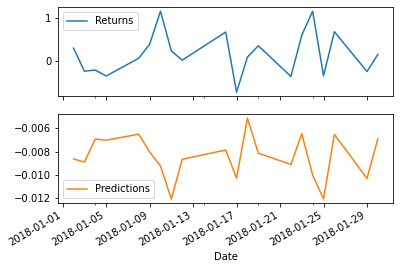

In [36]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [39]:
out_of_sample_results = y_test.to_frame()
out_of_sample_results["Out_of_Sample_Predictions"] = model.predict(X_test)
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Returns"],
    out_of_sample_results["Out_of_Sample_Predictions"]
)
rolling_rmse = np.sqrt(out_of_sample_mse )
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Rolling Out-of-Sample Root Mean Squared Error (RMSE): 0.41548233215135344


In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!

Out-of-Sample Root Mean Squared Error (RMSE): 0.41521675083603804


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [41]:
in_sample_results = y_train.to_frame()
in_sample_results["In_Sample_Predictions"] = model.predict(X_train)
in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In_Sample_Predictions"]
)
rolling_in_rmse = np.sqrt(in_sample_mse )
print(f"Rolling In Sample Root Mean Squared Error (RMSE): {rolling_in_rmse}")

Rolling In Sample Root Mean Squared Error (RMSE): 0.5966748205888165


In [14]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!

# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

In-sample Root Mean Squared Error (RMSE): 0.5658708047560468


# Conclusions

YOUR CONCLUSIONS HERE!